## 목적
- real_avg_arpu 도대체 왜이럴까

In [ ]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import pickle
import time
import os
import gc

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from dateutil.relativedelta import relativedelta
from datetime import datetime

import shap
shap.initjs()

from tigger.util.hive_tools import hive_connection, load_from_hive, load_to_hive, send_query

In [2]:
DATA_PATH = '/home/dmig/work/dominic_workspace/data/'
MODEL_PATH = '/home/dmig/work/dominic_workspace/model/'

## load data

In [3]:
df_merge = pd.read_pickle(os.path.join(DATA_PATH, 'eqp_merge_le.pkl'))
df_meta = pd.read_pickle(os.path.join(DATA_PATH, 'eqp_meta.pkl'))

df_merge.shape, df_meta.shape

((1494418, 330), (1679, 15))

In [6]:
with open(os.path.join(DATA_PATH, 'eqp_le_dict.pkl'), 'rb') as f:
    le_dict = pickle.load(f)

In [7]:
df_merge['label_price_range'] = df_merge['label_out_prc'].apply(lambda x: 1600000 if x > 1600000 else x)
df_merge['label_price_range'] = pd.cut(df_merge['label_price_range'], bins=np.arange(0,1600001, 400000), labels=np.arange(0,4))

In [8]:
# data
df_trn = df_merge[df_merge['ym'].isin(['201902', '201903', '201904', '201905'])]
df_val = df_merge[df_merge['ym']=='201906']
df_tst = df_merge[df_merge['ym']=='201907']

df_trn.shape, df_val.shape, df_tst.shape

((902188, 331), (255229, 331), (337001, 331))

In [9]:
label_cols = [c for c in df_trn.columns if 'label_' in c]

idx_col = 'svc_mgmt_num'
target_cols = ['label_mfact_nm', 'label_price_range', 'label_tablet_yn', 'label_note_yn', 'label_flagship_yn', 'label_disp_size_larg_yn']

feature_cols = [c for c in df_trn.columns if c not in [idx_col, 'ym', 'next_ym'] + label_cols ]

In [50]:
feature_cols = ['real_avg_arpu']

In [29]:
[c for c in feature_cols if 'real_' in c]

['real_avg_arpu',
 'real_data_use_gb_bf_m0',
 'real_data_use_gb_bf_m1',
 'real_data_use_gb_bf_m2',
 'real_arpu_bf_m3']

In [10]:
df_merge['only_lg'] = df_merge['label_mfact_nm'].apply(lambda x: 1 if x==1 else 0)

In [11]:
# data
df_trn = df_merge[df_merge['ym'].isin(['201902', '201903', '201904', '201905'])]
df_val = df_merge[df_merge['ym']=='201906']
df_tst = df_merge[df_merge['ym']=='201907']

df_trn.shape, df_val.shape, df_tst.shape

((902188, 332), (255229, 332), (337001, 332))

In [12]:
label_dict = {
    'only_lg': 'binary',
}

In [13]:
label_cols = [c for c in df_trn.columns if 'label_' in c]

idx_col = 'svc_mgmt_num'
target_cols = ['label_mfact_nm', 'label_price_range', 'label_tablet_yn', 'label_note_yn', 'label_flagship_yn', 'label_disp_size_larg_yn']

feature_cols = [c for c in df_trn.columns if c not in [idx_col, 'ym', 'next_ym'] + label_cols ]

In [39]:
yn_cols = [c for c in df_trn.columns if '_yn' in c]

In [40]:
yn_cols

['data_gift_recv_yn_bf_m2',
 'copn_data_u1_yn_bf_m0',
 'rmk_omd_yn',
 'smartwatch_yn',
 'nh00000059_yn',
 'data_gift_send_yn_bf_m0',
 'copn_data_u1_yn_bf_m1',
 'childwatch_yn',
 'family_marriage_yn',
 'tablet_yn',
 'na00002040_yn',
 'family_yn',
 'nh00000037_yn',
 'sec_dev_yn',
 'nh00000084_yn',
 'family_rep_yn',
 'family_child_yn',
 't_agr_t_eqpal_scrb_yn',
 'nh00000133_yn',
 'data_gift_recv_yn_bf_m0',
 'nh00000114_yn',
 'data_gift_send_yn_bf_m1',
 'nh00000103_yn',
 'nh00000039_yn',
 'na00004430_yn',
 'family_wire_comb_yn',
 'family_small_yn',
 'data_gift_send_yn_bf_m2',
 'data_gift_recv_yn_bf_m1',
 'copn_data_u1_yn_bf_m2',
 'old_eqp_yn',
 'smart_phon_yn',
 'note_yn',
 'disp_size_larg_yn',
 'flagship_yn',
 'label_tablet_yn',
 'label_note_yn',
 'label_disp_size_larg_yn',
 'label_flagship_yn']

In [41]:
del_cols = [idx_col, 'ym', 'next_ym', 'real_arpu_bf_m1', 'real_arpu_bf_m2', 'eqp_pet_nm', 'eqp_nm_rmk', 'only_lg', 
            'real_arpu_bf_m3', 'nh00000059_yn', 'nh00000037_yn', 'na00002040_yn', 'nh00000084_yn', 'nh00000133_yn',
           'nh00000114_yn', 'nh00000103_yn', 'nh00000039_yn', 'na00004430_yn'] + label_cols

In [42]:
feature_cols = [c for c in df_trn.columns if c not in del_cols ]

In [115]:
feature_cols = ['real_avg_arpu', 
#                 'othr_co_icall_call', 'flagship_yn', 'mfact_nm', 
#                 'real_arpu_bf_m1', 
#                 'app_use_traffic_insta',
#                 'days_from_eqp_acqr_dt'
               ]

In [116]:
def lgb_train(params, train_set, valid_sets):
    t1 = time.time()
    clf = lgb.train(lgb_params,
                    train_set=lgb_trn,
                    valid_sets=[lgb_trn, lgb_val],
                    num_boost_round=2000,
                    early_stopping_rounds=100,
                    verbose_eval=50)
    print('elapsed time:', time.time()-t1)
    return clf

In [117]:
clf_dict = {}

for label in ['only_lg']:
    print('='*50)
    print('label: ', label)
    
    # input
    lgb_trn = lgb.Dataset(df_trn[feature_cols], df_trn[label], feature_name=feature_cols)
    lgb_val = lgb.Dataset(df_val[feature_cols], df_val[label], feature_name=feature_cols)
    
    # problem type
    p_type = label_dict[label]
    print('p_type: ', p_type)
    
    # params
    lgb_params = {
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'num_threads': 60,
    }
    

    # train
    if p_type=='multi':
        lgb_params['objective'] = 'multiclass'
        lgb_params['num_class'] = df_trn[label].nunique()
        lgb_params['metric'] = 'multi_logloss'
        
    elif p_type=='binary':
        lgb_params['objective'] = 'binary'
        lgb_params['metric'] = 'auc'
        lgb_params['is_unbalance'] = True
        
    else:
        print('ERROR!')
        
    clf = lgb_train(lgb_params, lgb_trn, [lgb_trn, lgb_val])

    clf_dict[label] = clf
    print('')

label:  only_lg
p_type:  binary
Training until validation scores don't improve for 100 rounds.
[50]	training's auc: 0.587202	valid_1's auc: 0.570732
[100]	training's auc: 0.587517	valid_1's auc: 0.570445
Early stopping, best iteration is:
[5]	training's auc: 0.586512	valid_1's auc: 0.570979
elapsed time: 7.7978174686431885



        acc   recall  precision  f1_score       auc
0  0.704876  0.48285   0.116882  0.188206  0.653751
         pred: 1  pred: 0
true: 1    11529    12348
true: 0    87109   226015


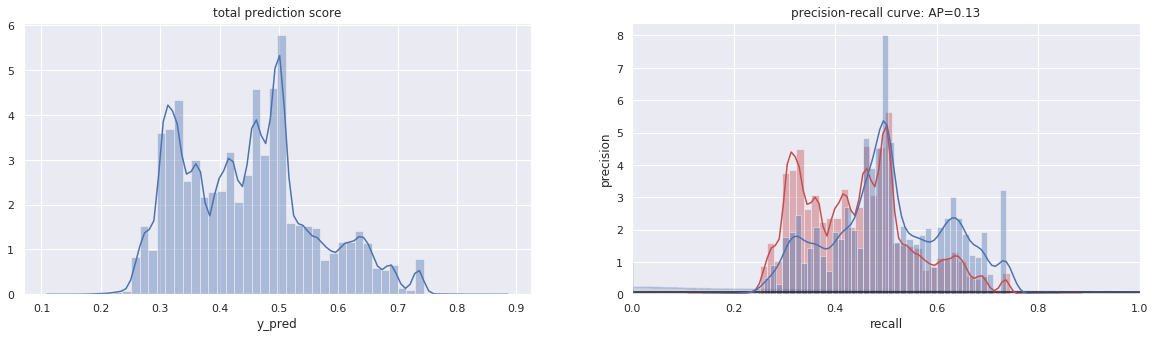

In [92]:
from sm_utils import evaluate
label = 'only_lg'
a = evaluate(df_tst[feature_cols], df_tst[label], clf_dict[label], clf_name='lgb' )

In [118]:
df_sample = df_trn.sample(n=100000)

In [119]:
explainer_lg = shap.TreeExplainer(clf_dict['only_lg'])
shap_value_lg = explainer_lg.shap_values(df_sample[feature_cols])

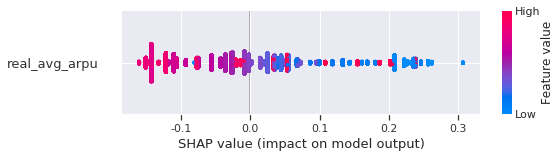

In [120]:
shap.summary_plot(shap_value_lg[1], df_sample[feature_cols])

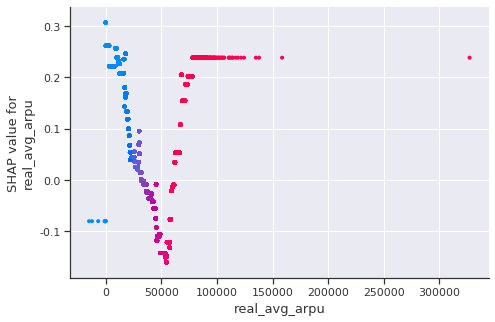

In [121]:
shap.dependence_plot('real_avg_arpu', shap_value_lg[1], df_sample[feature_cols])

In [97]:
df_sv = pd.DataFrame(shap_value_lg[1], columns=feature_cols, index=df_sample.index)

In [99]:
target_feature = 'real_avg_arpu'

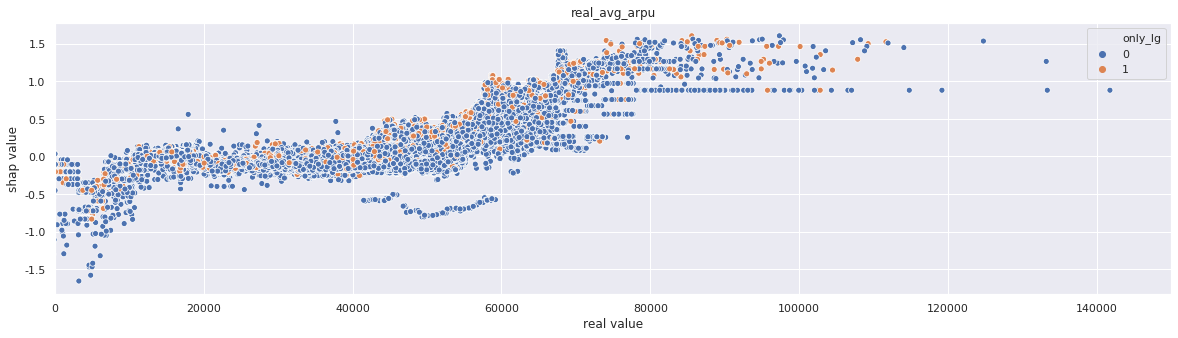

In [101]:
sns.set(rc={'figure.figsize': (20,5)})
plt.xlim(0,150000)
sns.scatterplot(df_sample[target_feature].values,
                df_sv[target_feature].values, hue=df_sample['only_lg'])
plt.title("{}".format(target_feature))
plt.xlabel("real value")
plt.ylabel("shap value")
plt.show()

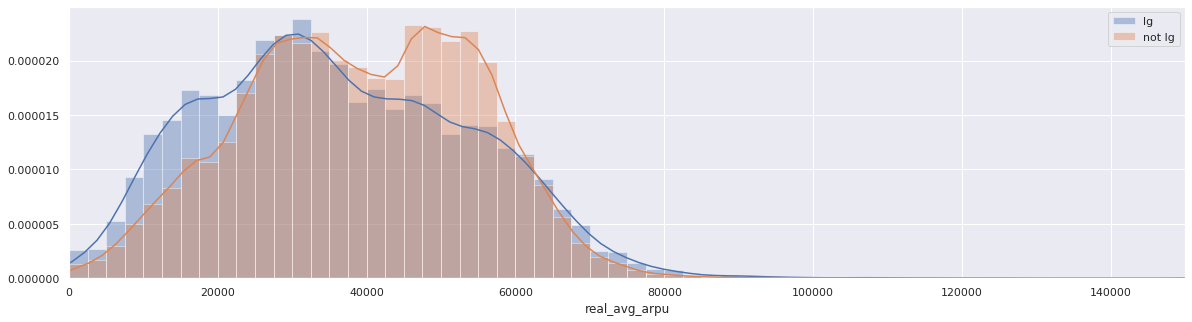

In [49]:
sns.set(rc={'figure.figsize': (20,5)})
plt.xlim(0,150000)
sns.distplot(df_sample[df_sample['only_lg']==1]['real_avg_arpu'], label='lg', bins=np.arange(0, 100000, 2500))
sns.distplot(df_sample[df_sample['only_lg']==0]['real_avg_arpu'], label='not lg', bins=np.arange(0, 100000, 2500))
plt.legend()

In [103]:
feature_cols

['real_avg_arpu', 'real_arpu_bf_m1']

In [105]:
df_sample['diff'] = df_sample['real_avg_arpu'] - df_sample['real_arpu_bf_m1']

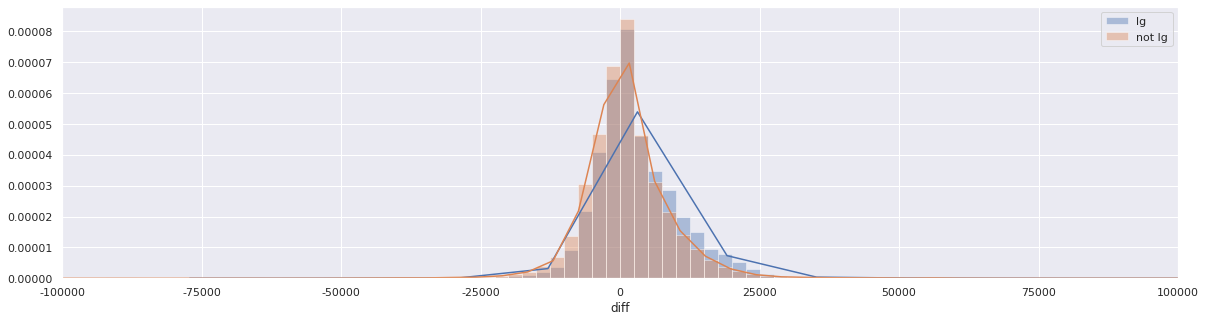

In [110]:
plt.xlim(-100000,100000)
sns.distplot(df_sample[df_sample['only_lg']==1]['diff'], bins=np.arange(-100000, 100000, 2500), label='lg')
sns.distplot(df_sample[df_sample['only_lg']==0]['diff'], bins=np.arange(-100000, 100000, 2500), label='not lg')
plt.legend()

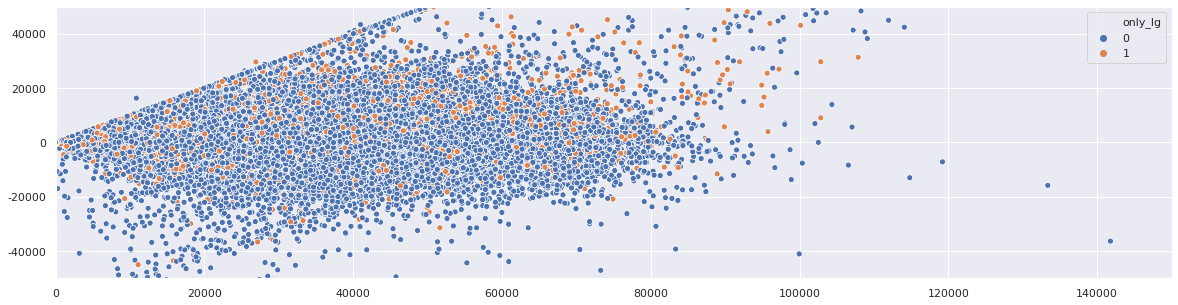

In [114]:
sns.set(rc={'figure.figsize': (20,5)})
plt.xlim(0,150000)
plt.ylim(-50000,50000)

sns.scatterplot(df_sample['real_avg_arpu'].values,
                df_sample['diff'].values, hue=df_sample['only_lg'])

In [ ]:
sns.set(rc={'figure.figsize': (20,5)})
plt.xlim(0,150000)
sns.scatterplot(df_sample[target_feature].values,
                df_sv[target_feature].values, hue=df_sample['only_lg'])
plt.title("{}".format(target_feature))
plt.xlabel("real value")
plt.ylabel("shap value")
plt.show()

In [ ]:
shap.force_plot(explainer_lg.expected_value[1], shap_value_lg[1][2,:], df_sample.iloc[2,:][feature_cols])

In [104]:
shap.force_plot(explainer_lg.expected_value[1], shap_value_lg[1][2,:], df_sample.iloc[2,:][feature_cols])